# How to do parallel aggregation of data

## Compute SSH variability and compare to AVISO

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import glob
import intake
import dask
from scipy.interpolate import NearestNDInterpolator
from scipy.spatial import cKDTree

In [2]:
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

In [3]:
print(list(cat['dkrz.disk.model-output.ifs-fesom2-sr.eerie-control-1950.ocean.native']))

['daily', 'monthly_center', 'monthly_edge', 'elem_grid', 'node_grid']


We are going to work with daily 2D data on orifinal grid

In [4]:
data = cat['dkrz.disk.model-output.ifs-fesom2-sr.eerie-control-1950.ocean.native']['daily'].to_dask()

In [5]:
data

<xarray.Dataset>
Dimensions:  (time: 730, x: 7402886)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T23:54:00 ... 1951-12-31T23:54:00
Dimensions without coordinates: x
Data variables:
    MLD1     (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    MLD2     (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    a_ice    (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    m_ice    (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    ssh      (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    sss      (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    sst      (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    uice     (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
    vice     (time, x) float32 dask.array<chunksize=(31, 7402886), meta=np.ndarray>
Attributes: (12/21)
    CDI:                                 Climate Data Interface version 2.2.4...
    Conventions:                         CF-1.6
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       d6a683a9
    FESOM_MeshPath:                      /scratch/a/a270228/ifs_inputs/fesom/...
    ...                                  ...
    FESOM_evp_rheol_steps:               120
    FESOM_opt_visc:                      7
    FESOM_use_wsplit:                    1
    FESOM_autorotate_back_to_geo:        1
    history:                             Wed Nov 01 00:21:09 2023: cdo --ecco...
    CDO:                                 Climate Data Operators version 2.2.2...

we will take SSH, and compute it's STD. Before we do that, we have to create a bunch of Dask workers, that will do job in parallel. Configuration below assimes you took small 50GB memory jupyterHub instance. If you have less or more resources, adjust number of workers and memory limit. `n_workers * memory_limit` should be less than memory available for you.

In [6]:
from dask.distributed import Client
import dask
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
dask.config.set({'temporary_directory': '/scratch/a/a270088/dask/'})
# client = Client(n_workers=5, threads_per_worker=1, memory_limit='50GB')
client = Client(n_workers=5, threads_per_worker=1, memory_limit='10GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/a270088/levante-spawner-advanced//proxy/8787/status,
Dashboard: /user/a270088/levante-spawner-advanced//proxy/8787/status,Workers: 5
Total threads: 5,Total memory: 46.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34771,Workers: 5
Dashboard: /user/a270088/levante-spawner-advanced//proxy/8787/status,Total threads: 5
Started: Just now,Total memory: 46.57 GiB
Comm: tcp://127.0.0.1:36147,Total threads: 1
Dashboard: /user/a270088/levante-spawner-advanced//proxy/46041/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:36277,


In [7]:
ssh_std = data['ssh'].sel(time=slice('1950','1951')).std(dim='time').compute()

In [8]:
grid = cat['dkrz.disk.model-output.ifs-fesom2-sr.eerie-control-1950.ocean.native']['node_grid'].to_dask()
model_lon_fesom = grid.grid_center_lon.values
model_lat_fesom = grid.grid_center_lat.values
# put coordinates to -180 180 format
model_lon_fesom = np.where(model_lon_fesom>180, model_lon_fesom-360, model_lon_fesom)

In [9]:
lon = np.linspace(-180, 180, 360*4)
lat = np.linspace(-90, 90, 180*4)
lon2, lat2 = np.meshgrid(lon, lat)

points_fesom = np.vstack((model_lon_fesom, model_lat_fesom)).T
data_sample = ssh_std

nn_interpolation = NearestNDInterpolator(points_fesom, data_sample.values)
interpolated_nn = nn_interpolation((lon2, lat2))

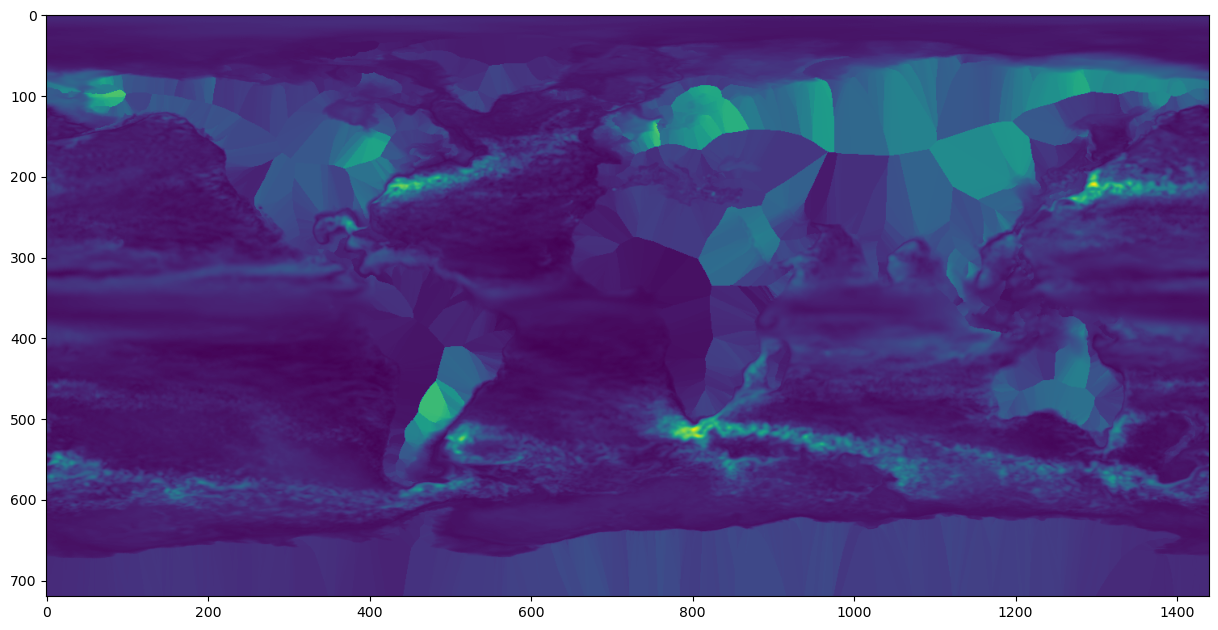

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

In [11]:
def lon_lat_to_cartesian(lon, lat, R=6371000):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z

In [12]:
def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1, workers=2):
    """
    Creates KDTree object and query it for indexes of points in FESOM mesh that are close to the
    points of the target grid. Also return distances of the original points to target points.
    Parameters
    ----------
    mesh : fesom_mesh object
        pyfesom mesh representation
    lons/lats : array
        2d arrays with target grid values.
    k : int
        k-th nearest neighbors to return.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors.
    inds : ndarray of ints
        The locations of the neighbors in data.
    """
    xs, ys, zs = lon_lat_to_cartesian(model_lon, model_lat)
    xt, yt, zt = lon_lat_to_cartesian(lons.flatten(), lats.flatten())

    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k, workers=workers)

    return distances, inds

In [13]:
distances, inds = create_indexes_and_distances(model_lon_fesom, model_lat_fesom, lon2, lat2, k=1, workers=10)

In [14]:
radius_of_influence=13000
data_interpolated = data_sample.values[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

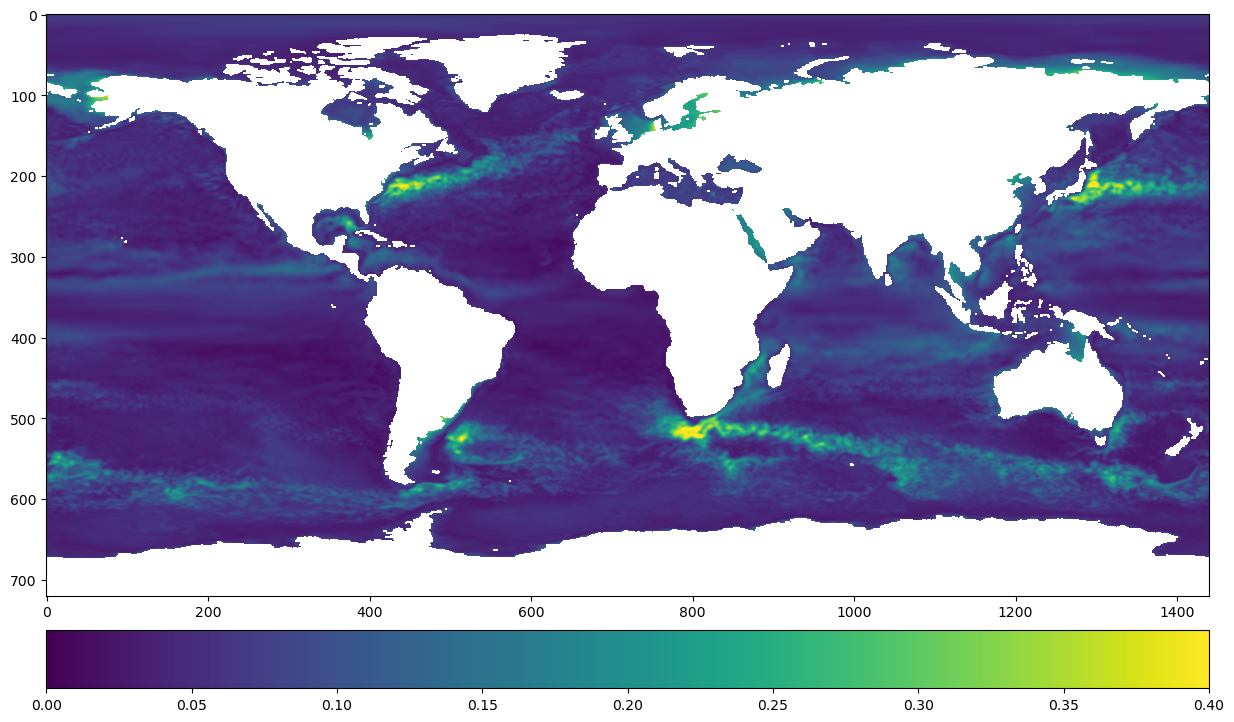

In [15]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(data_interpolated), vmin=0, vmax=0.4)
plt.colorbar(orientation='horizontal', pad=0.03)

In [17]:
cat_obs = intake.open_catalog('https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml')\
                          ['dkrz.disk.observations']

In [18]:
aviso = cat_obs['AVISO']['ssh-L4']['daily'].to_dask()

In [19]:
ssh_aviso = aviso.adt.sel(time= slice('2000', '2001')).std(dim='time').compute()

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


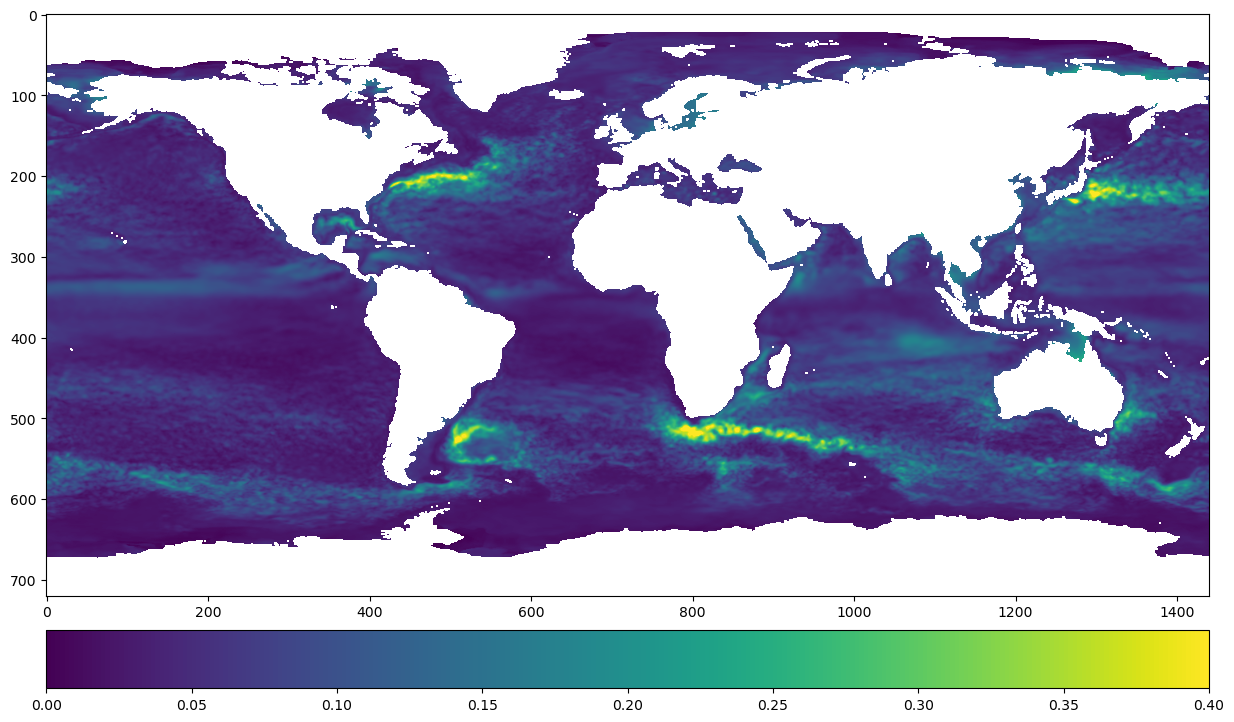

In [20]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(ssh_aviso.values), vmin=0, vmax=0.4)
plt.colorbar(orientation='horizontal', pad=0.03)